## Implementation of LSTM-RNN with PyTorch

In [1]:
# import Yahoo Finance module to obtain dataset

import yfinance as yf

In [3]:
# import basic numerical and graphical tools

import time
import itertools
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# import machine learning frameworks

from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor

In [7]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


### Proposed data acquisition

In [10]:
data = pd.read_csv('dataset_others.csv')
data.head()
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'ALV_Open', 'ALV_High', 'ALV_Low',
       ...
       '^IXIC_RSI', '^IXIC_k_percent', '^IXIC_r_percent', '^IXIC_MACD',
       '^IXIC_MACD_EMA', '^IXIC_ROC', '^IXIC_PVT', '^IXIC_Bollinger_Upper',
       '^IXIC_Bollinger_Lower', 'DNZOY_Close_pred'],
      dtype='object', length=553)

In [12]:
tickers = ['F', 'ALV', 'FDX', 'DNZOY', 'ASEKY', 'JCI', 'GM', 'TM', 'CL=F', 'X',  # Company tickers
           'EURUSD=X', 'CHFUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CADUSD=X', 'INRUSD=X', 'RUBUSD=X', 'TRYUSD=X',  # Currencies
           '^IRX', 'JPM', 'BAC', 'C', 'WFC',  # Financial companies and IRX
           '^IXIC', '^GSPC', '^DJI'  # NASDAQ, S&P 500, Dow Jones
          ]
raw_data = yf.download(tickers, period='5y')

[*********************100%***********************]  26 of 26 completed


In [14]:
raw_data

Price                      Adj Close                                         \
Ticker                           ALV  ASEKY        BAC          C  CADUSD=X   
Date                                                                          
2019-10-31 00:00:00+00:00        NaN    NaN        NaN        NaN  0.759567   
2019-11-01 00:00:00+00:00  70.844963  13.18  28.084768  61.557415  0.759446   
2019-11-04 00:00:00+00:00  73.797569  13.18  28.614674  62.649509  0.761035   
2019-11-05 00:00:00+00:00  75.421066  13.18  28.985601  62.382759  0.760364   
2019-11-06 00:00:00+00:00  75.278336  13.18  28.959114  62.040962  0.760398   
...                              ...    ...        ...        ...       ...   
2024-10-28 00:00:00+00:00  97.080002  10.65  42.619999  64.160004  0.719652   
2024-10-29 00:00:00+00:00  96.019997  10.65  42.529999  64.690002  0.719953   
2024-10-30 00:00:00+00:00  94.809998  10.13  42.310001  64.500000  0.718763   
2024-10-31 00:00:00+00:00  92.879997   9.55  41.820000  64.169998  0.718066   
2024-11-01 00:00:00+00:00        NaN    NaN        NaN        NaN       NaN   

Price                                                                        \
Ticker                     CHFUSD=X       CL=F   DNZOY  EURUSD=X          F   
Date                                                                          
2019-10-31 00:00:00+00:00  1.011010  54.180000     NaN  1.115449        NaN   
2019-11-01 00:00:00+00:00  1.013777  56.200001  11.390  1.115710   7.220750   
2019-11-04 00:00:00+00:00  1.014363  56.540001  11.395  1.116657   7.310098   
2019-11-05 00:00:00+00:00  1.011849  57.230000  11.850  1.112855   7.326343   
2019-11-06 00:00:00+00:00  1.007658  56.349998  11.615  1.107420   7.245118   
...                             ...        ...     ...       ...        ...   
2024-10-28 00:00:00+00:00  1.151464  67.379997  13.980  1.079657  11.370000   
2024-10-29 00:00:00+00:00  1.156257  67.209999  14.000  1.081677  10.410000   
2024-10-30 00:00:00+00:00  1.153110  68.610001  14.250  1.082064  10.470000   
2024-10-31 00:00:00+00:00  1.157823  70.519997  14.300  1.088613  10.290000   
2024-11-01 00:00:00+00:00       NaN        NaN     NaN       NaN        NaN   

Price                      ...   Volume                              \
Ticker                     ... JPYUSD=X RUBUSD=X        TM TRYUSD=X   
Date                       ...                                        
2019-10-31 00:00:00+00:00  ...      0.0      0.0       NaN      0.0   
2019-11-01 00:00:00+00:00  ...      0.0      0.0  115800.0      0.0   
2019-11-04 00:00:00+00:00  ...      0.0      0.0  137900.0      0.0   
2019-11-05 00:00:00+00:00  ...      0.0      0.0   80500.0      0.0   
2019-11-06 00:00:00+00:00  ...      0.0      0.0   98900.0      0.0   
...                        ...      ...      ...       ...      ...   
2024-10-28 00:00:00+00:00  ...      0.0      0.0  457000.0      0.0   
2024-10-29 00:00:00+00:00  ...      0.0      0.0  357100.0      0.0   
2024-10-30 00:00:00+00:00  ...      0.0      0.0  222800.0      0.0   
2024-10-31 00:00:00+00:00  ...      0.0      0.0  234644.0      0.0   
2024-11-01 00:00:00+00:00  ...      NaN      NaN       NaN      NaN   

Price                                                                         \
Ticker                            WFC           X         ^DJI         ^GSPC   
Date                                                                           
2019-10-31 00:00:00+00:00         NaN         NaN          NaN           NaN   
2019-11-01 00:00:00+00:00  16359300.0  46902900.0  270870000.0  3.956290e+09   
2019-11-04 00:00:00+00:00  17559900.0  17313300.0  273030000.0  4.178040e+09   
2019-11-05 00:00:00+00:00  25965300.0  13470100.0  286350000.0  4.490590e+09   
2019-11-06 00:00:00+00:00  22051100.0  10890800.0  237910000.0  4.465510e+09   
...                               ...         ...          ...           ...   
2024-10-28 00:00:00+00:00  16158900.0   2169100.0  284770000.0  3.69128

In [16]:
raw_data = raw_data.dropna()
raw_data

Price                      Adj Close                                         \
Ticker                           ALV  ASEKY        BAC          C  CADUSD=X   
Date                                                                          
2019-11-01 00:00:00+00:00  70.844963  13.18  28.084768  61.557415  0.759446   
2019-11-04 00:00:00+00:00  73.797569  13.18  28.614674  62.649509  0.761035   
2019-11-05 00:00:00+00:00  75.421066  13.18  28.985601  62.382759  0.760364   
2019-11-06 00:00:00+00:00  75.278336  13.18  28.959114  62.040962  0.760398   
2019-11-07 00:00:00+00:00  76.669899  13.18  29.347706  63.199738  0.758403   
...                              ...    ...        ...        ...       ...   
2024-10-24 00:00:00+00:00  95.040001  10.65  42.650002  63.000000  0.722716   
2024-10-25 00:00:00+00:00  94.739998  10.65  41.889999  61.759998  0.721850   
2024-10-28 00:00:00+00:00  97.080002  10.65  42.619999  64.160004  0.719652   
2024-10-29 00:00:00+00:00  96.019997  10.65  42.529999  64.690002  0.719953   
2024-10-30 00:00:00+00:00  94.809998  10.13  42.310001  64.500000  0.718763   

Price                                                                        \
Ticker                     CHFUSD=X       CL=F   DNZOY  EURUSD=X          F   
Date                                                                          
2019-11-01 00:00:00+00:00  1.013777  56.200001  11.390  1.115710   7.220750   
2019-11-04 00:00:00+00:00  1.014363  56.540001  11.395  1.116657   7.310098   
2019-11-05 00:00:00+00:00  1.011849  57.230000  11.850  1.112855   7.326343   
2019-11-06 00:00:00+00:00  1.007658  56.349998  11.615  1.107420   7.245118   
2019-11-07 00:00:00+00:00  1.007587  57.150002  11.650  1.107040   7.220750   
...                             ...        ...     ...       ...        ...   
2024-10-24 00:00:00+00:00  1.153749  70.190002  13.810  1.078051  11.240000   
2024-10-25 00:00:00+00:00  1.154908  71.779999  13.800  1.082415  11.070000   
2024-10-28 00:00:00+00:00  1.151464  67.379997  13.980  1.079657  11.370000   
2024-10-29 00:00:00+00:00  1.156257  67.209999  14.000  1.081677  10.410000   
2024-10-30 00:00:00+00:00  1.153110  68.610001  14.250  1.082064  10.470000   

Price                      ...   Volume                              \
Ticker                     ... JPYUSD=X RUBUSD=X        TM TRYUSD=X   
Date                       ...                                        
2019-11-01 00:00:00+00:00  ...      0.0      0.0  115800.0      0.0   
2019-11-04 00:00:00+00:00  ...      0.0      0.0  137900.0      0.0   
2019-11-05 00:00:00+00:00  ...      0.0      0.0   80500.0      0.0   
2019-11-06 00:00:00+00:00  ...      0.0      0.0   98900.0      0.0   
2019-11-07 00:00:00+00:00  ...      0.0      0.0  179800.0      0.0   
...                        ...      ...      ...       ...      ...   
2024-10-24 00:00:00+00:00  ...      0.0      0.0  288500.0      0.0   
2024-10-25 00:00:00+00:00  ...      0.0      0.0  273900.0      0.0   
2024-10-28 00:00:00+00:00  ...      0.0      0.0  457000.0      0.0   
2024-10-29 00:00:00+00:00  ...      0.0      0.0  357100.0      0.0   
2024-10-30 00:00:00+00:00  ...      0.0      0.0  222800.0      0.0   

Price                                                                         \
Ticker                            WFC           X         ^DJI         ^GSPC   
Date                                                                           
2019-11-01 00:00:00+00:00  16359300.0  46902900.0  270870000.0  3.956290e+09   
2019-11-04 00:00:00+00:00  17559900.0  17313300.0  273030000.0  4.178040e+09   
2019-11-05 00:00:00+00:00  25965300.0  13470100.0  286350000.0  4.490590e+09   
2019-11-06 00:00:00+00:00  22051100.0  10890800.0  237910000.0  4.465510e+09   
2019-11-07 00:00:00+00:00  23452500.0  16882800.0  259020000.0  4.151990e+09   
...                               ...         ...          ...           ...   
2024-10-24 00:00:00+00:00  18393300.0   2553200.0  282680000.0  3.54303

In [18]:
close_data = pd.DataFrame(data=raw_data['Close']).reset_index()
close_data['Date'] = pd.to_datetime(close_data['Date']).dt.date
close_data = close_data.set_index('Date')
close_data.head()

Ticker,ALV,ASEKY,BAC,C,CADUSD=X,CHFUSD=X,CL=F,DNZOY,EURUSD=X,F,...,JPYUSD=X,RUBUSD=X,TM,TRYUSD=X,WFC,X,^DJI,^GSPC,^IRX,^IXIC
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,79.419998,13.18,31.799999,73.839996,0.759446,1.013777,56.200001,11.390,1.115710,8.89,...,0.009260,0.015603,139.830002,0.175107,52.180000,13.21,27347.359375,3066.909912,1.485,8386.400391
2019-11-04,82.730003,13.18,32.400002,75.150002,0.761035,1.014363,56.540001,11.395,1.116657,9.00,...,0.009240,0.015772,140.559998,0.175352,52.720001,13.30,27462.109375,3078.270020,1.503,8433.200195
2019-11-05,84.550003,13.18,32.820000,74.830002,0.760364,1.011849,57.230000,11.850,1.112855,9.02,...,0.009200,0.015761,140.740005,0.174420,53.299999,13.10,27492.630859,3074.620117,1.518,8434.679688
2019-11-06,84.389999,13.18,32.790001,74.419998,0.760398,1.007658,56.349998,11.615,1.107420,8.92,...,0.009162,0.015761,140.369995,0.173822,53.799999,12.84,27492.560547,3076.780029,1.515,8410.629883
2019-11-07,85.949997,13.18,33.230000,75.809998,0.758403,1.007587,57.150002,11.650,1.107040,8.89,...,0.009182,0.015670,142.860001,0.173904,54.000000,13.56,27674.800781,3085.179932,1.518,8434.519531


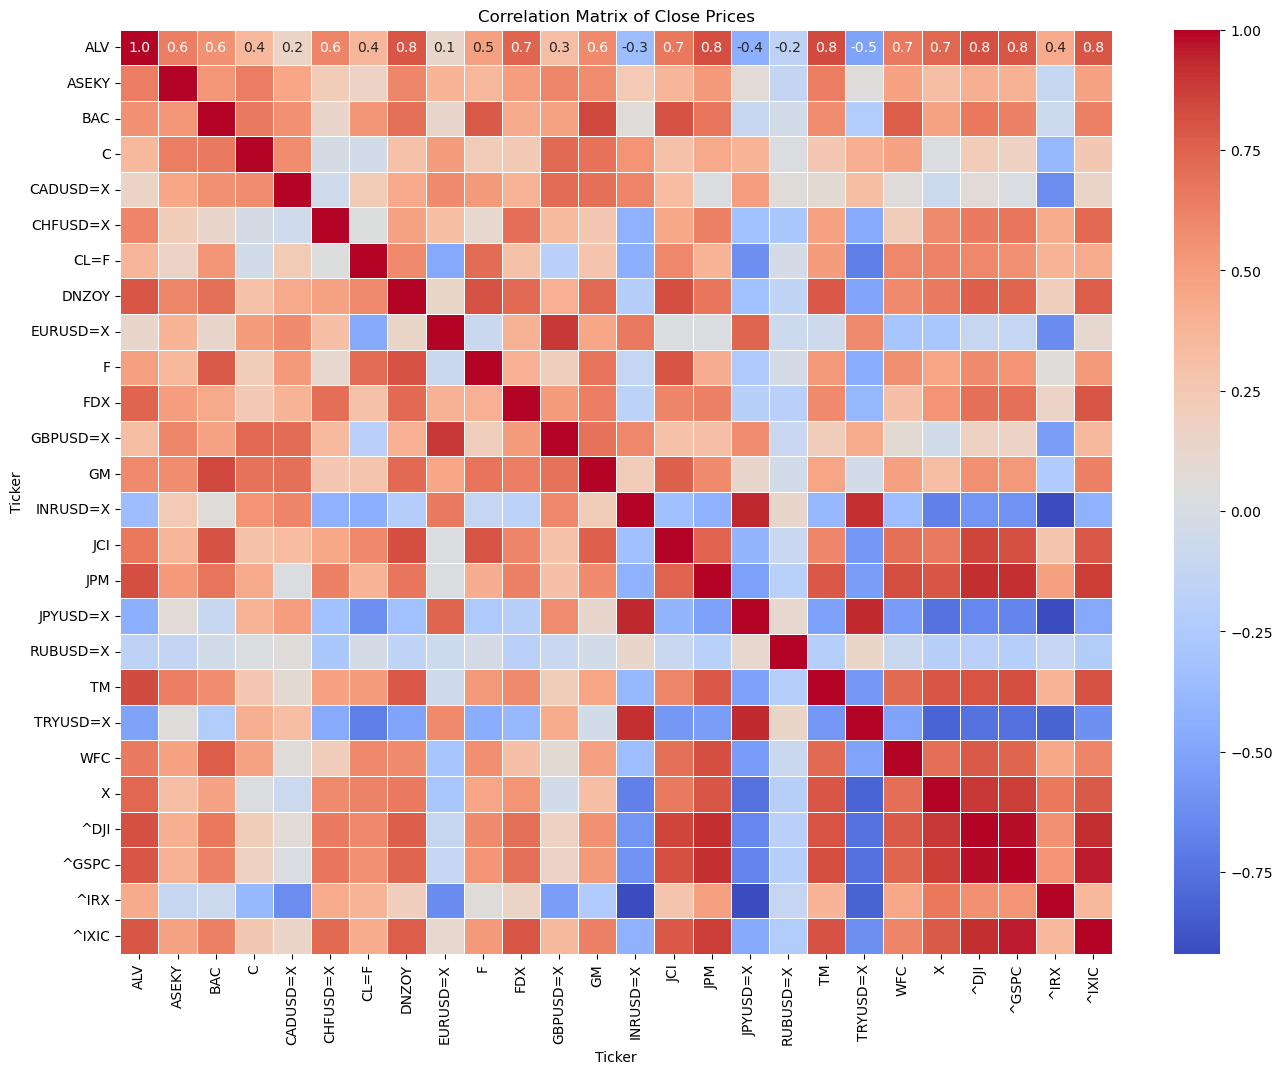

In [20]:
corr_mat = close_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.1f')
plt.title('Correlation Matrix of Close Prices')
plt.show()

In [22]:
ford_corr = corr_mat['F']
highly_corr_tickers = ford_corr[abs(ford_corr) > 0.4]
highly_corr_tickers

Ticker
ALV         0.489859
BAC         0.775961
CADUSD=X    0.516114
CL=F        0.708606
DNZOY       0.809055
F           1.000000
FDX         0.406850
GM          0.684315
JCI         0.802837
JPM         0.417133
TM          0.521611
TRYUSD=X   -0.447084
WFC         0.571346
X           0.463324
^DJI        0.581435
^GSPC       0.546268
^IXIC       0.516765
Name: F, dtype: float64

### Define and calculate indicators

In [25]:
# Gain, Loss, Avg_Gain, and Avg_Loss
def gain_loss(df):
    df['Change'] = df['Close'].diff()
    df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
    df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)
    df['Avg_Gain'] = df['Gain'].rolling(window=14).mean()
    df['Avg_Loss'] = df['Loss'].rolling(window=14).mean()
    return df

# Simple Moving Average (SMA)
def SMA(df, window=20):
    df['SMA'] = df['Close'].rolling(window=window).mean()
    return df

# Exponential Moving Average (EMA)
def EMA(df, window=20):
    df['EMA'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

# Relative Strength Index (RSI)
def RSI(df):
    df['change_in_price'] = df['Close'].diff()
    up_df, down_df = df[['change_in_price']].copy(), df[['change_in_price']].copy()
    up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    ewma_up = up_df['change_in_price'].ewm(span=14).mean()
    ewma_down = down_df['change_in_price'].ewm(span=14).mean()
    relative_strength = ewma_up / ewma_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + relative_strength))
    return df

# Stochastic Oscillator
def SO(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['k_percent'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    return df

# Williams %R
def r_percent(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['r_percent'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))
    return df

# Moving Average Convergence Divergence (MACD)
def MACD(df):
    ema_26 = df['Close'].ewm(span=26).mean()
    ema_12 = df['Close'].ewm(span=12).mean()
    macd = ema_12 - ema_26
    df['MACD'] = macd
    df['MACD_EMA'] = macd.ewm(span=9).mean()
    return df

# Price Rate of Change (PROC)
def ROC(df, n=12):
    df['ROC'] = df['Close'].pct_change(periods=n) * 100
    return df

# Price Volume Trend (PVT)
def PVT(df):
    df['PVT'] = (df['Close'].pct_change() * df['Volume']).cumsum()
    return df

# Bollinger Bands
def Bollinger_Bands(df, window=20):
    sma = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['Bollinger_Upper'] = sma + (rolling_std * 2)
    df['Bollinger_Lower'] = sma - (rolling_std * 2)
    return df

In [27]:
def calculate_indicators(df, ticker):
    df = gain_loss(df)
    df = SMA(df)
    df = EMA(df)
    df = RSI(df)
    df = SO(df)
    df = r_percent(df)
    df = MACD(df)
    df = ROC(df)
    df = PVT(df)
    df = Bollinger_Bands(df)
    
    df = df.rename(columns=lambda col: f"{ticker}_{col}")
    
    return df

In [29]:
def create_dataset(data, tickers, target):
    df_features = pd.DataFrame()
    
    # Add the indicators and volume for each selected feature
    for ticker in tickers.index:
        try:
            # Extract the individual ticker data (Close, High, Low, Volume)
            ticker_data = pd.DataFrame({
                'Close': data['Close'][ticker],
                'High': data['High'][ticker],
                'Low': data['Low'][ticker],
                'Volume': data['Volume'][ticker]
            })
        except KeyError:
            print(f"Ticker '{ticker}' not found in data. Skipping.")
            continue
        
        # Calculate indicators and add to the dataset
        indicator_data = calculate_indicators(ticker_data.copy(), ticker)
        
        # Merge the calculated indicators into the final feature dataset
        df_features = pd.concat([df_features, indicator_data], axis=1)
    
    # Add Ford's closing price as the predictor variable
    df_features[f'{target}_Close'] = data['Close'][target]
    
    # # Apply the prediction_class function on Denso's Close price
    # df_features = prediction_class(df_features)
    
    return df_features

In [31]:
dataset_reg = create_dataset(raw_data, highly_corr_tickers, target='F')
dataset_reg = dataset_reg.dropna()
dataset_reg

,ALV_Close,ALV_High,ALV_Low,ALV_Volume,ALV_Change,ALV_Gain,ALV_Loss,ALV_Avg_Gain,ALV_Avg_Loss,ALV_SMA,...,^IXIC_change_in_price,^IXIC_RSI,^IXIC_k_percent,^IXIC_r_percent,^IXIC_MACD,^IXIC_MACD_EMA,^IXIC_ROC,^IXIC_PVT,^IXIC_Bollinger_Upper,^IXIC_Bollinger_Lower
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29 00:00:00+00:00,81.720001,82.389999,81.449997,218400.0,-1.190002,0.000000,1.190002,0.358572,0.686429,82.685000,...,-39.709961,71.484096,85.579120,-14.420880,35.491936,22.288927,2.113811,7.216009e+07,8695.155831,8339.999051
2019-12-02 00:00:00+00:00,82.150002,83.129997,81.919998,264900.0,0.430000,0.430000,0.000000,0.389286,0.587857,82.821500,...,-97.479492,49.884534,47.822842,-52.177158,30.867885,24.020691,1.012610,4.695854e+07,8694.285715,8359.028152
2019-12-03 00:00:00+00:00,80.860001,81.739998,80.320000,360700.0,-1.290001,0.000000,1.290001,0.389286,0.617857,82.728000,...,-47.350586,42.659907,31.510603,-68.489397,23.743992,23.964940,0.490860,3.414402e+07,8692.855293,8369.202520
2019-12-04 00:00:00+00:00,81.139999,82.169998,81.099998,323400.0,0.279999,0.279999,0.000000,0.409286,0.520714,82.557500,...,46.030273,50.673002,48.526725,-51.473275,21.064791,23.381466,0.302545,4.580669e+07,8693.569021,8381.687815
2019-12-05 00:00:00+00:00,82.089996,82.089996,81.239998,704300.0,0.949997,0.949997,0.000000,0.470000,0.520714,82.442500,...,4.030273,51.359718,50.016606,-49.983394,19.012351,22.503497,0.242806,4.681036e+07,8690.139796,8401.124072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24 00:00:00+00:00,95.040001,98.559998,94.269997,1043900.0,-1.459999,0.000000,1.459999,0.769285,0.673571,94.640500,...,138.839844,55.133890,71.523698,-28.476302,180.946482,192.693583,1.279059,3.443445e+09,18680.083517,17828.360233
2024-10-25 00:00:00+00:00,94.739998,95.410004,94.320000,501200.0,-0.300003,0.000000,0.300003,0.769285,0.627857,94.609500,...,103.119141,60.291622,75.525088,-24.474912,180.259053,190.206677,1.240952,3.477602e+09,18710.730026,17837.615677
2024-10-28 00:00:00+00:00,97.080002,97.290001,94.940002,815400.0,2.340004,2.340004,0.000000,0.870714,0.627857,94.795000,...,48.580078,62.627040,77.949288,-22.050712,181.541568,188.473655,1.559665,3.492402e+09,18746.540843,17839.606813


In [33]:
dataset_reg['F_Close']

Date
2019-11-29 00:00:00+00:00     9.06
2019-12-02 00:00:00+00:00     9.01
2019-12-03 00:00:00+00:00     8.89
2019-12-04 00:00:00+00:00     8.95
2019-12-05 00:00:00+00:00     8.93
                             ...  
2024-10-24 00:00:00+00:00    11.24
2024-10-25 00:00:00+00:00    11.07
2024-10-28 00:00:00+00:00    11.37
2024-10-29 00:00:00+00:00    10.41
2024-10-30 00:00:00+00:00    10.47
Name: F_Close, Length: 1238, dtype: float64

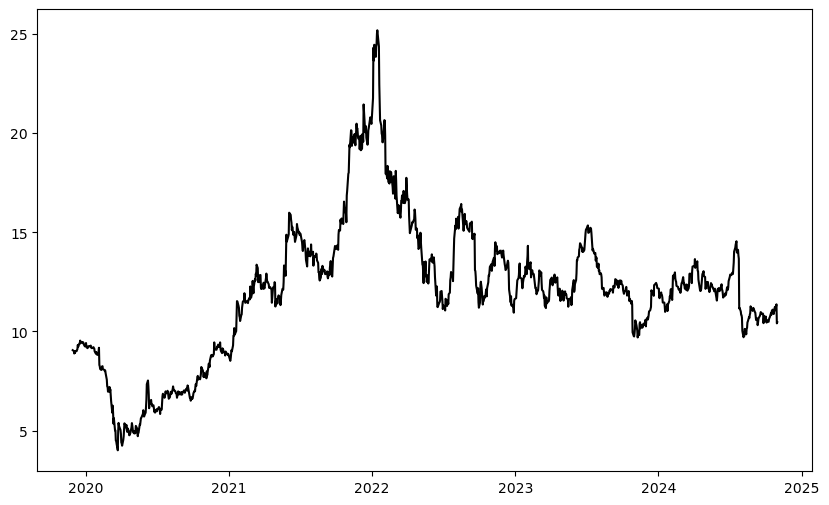

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dataset_reg['F_Close'], color='k')
plt.show()

### Transform the data to scale

In [38]:
scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_data = {}
for column in dataset_reg.columns:
    scaled_data[column] = scaler.fit_transform(dataset_reg[column].values.reshape(-1, 1)).reshape(-1)

scaled_dataset_reg = pd.DataFrame(scaled_data, index=dataset_reg.index)
scaled_dataset_reg

,ALV_Close,ALV_High,ALV_Low,ALV_Volume,ALV_Change,ALV_Gain,ALV_Loss,ALV_Avg_Gain,ALV_Avg_Loss,ALV_SMA,...,^IXIC_change_in_price,^IXIC_RSI,^IXIC_k_percent,^IXIC_r_percent,^IXIC_MACD,^IXIC_MACD_EMA,^IXIC_ROC,^IXIC_PVT,^IXIC_Bollinger_Upper,^IXIC_Bollinger_Lower
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29 00:00:00+00:00,-0.065782,-0.075532,-0.031327,-0.975996,-0.047480,-1.000000,-0.782051,-0.752650,-0.526670,-0.083262,...,0.075026,0.506634,0.711582,0.711582,0.299928,0.240966,0.240365,-0.519363,-0.901868,-0.653032
2019-12-02 00:00:00+00:00,-0.056112,-0.058595,-0.020810,-0.968490,0.111111,-0.909569,-1.000000,-0.718885,-0.604155,-0.079794,...,0.008289,-0.055121,-0.043543,-0.043543,0.290524,0.245029,0.187481,-0.529975,-0.902028,-0.649756
2019-12-03 00:00:00+00:00,-0.085123,-0.090410,-0.056612,-0.953026,-0.057269,-1.000000,-0.763736,-0.718885,-0.580573,-0.082170,...,0.066199,-0.243016,-0.369788,-0.369788,0.276036,0.244898,0.162425,-0.535371,-0.902291,-0.648004
2019-12-04 00:00:00+00:00,-0.078826,-0.080568,-0.039159,-0.959047,0.096427,-0.941115,-1.000000,-0.696898,-0.656934,-0.086502,...,0.174075,-0.034614,-0.029465,-0.029465,0.270587,0.243529,0.153381,-0.530460,-0.902160,-0.645855
2019-12-05 00:00:00+00:00,-0.057461,-0.082399,-0.036026,-0.897561,0.162016,-0.800211,-1.000000,-0.630154,-0.656934,-0.089425,...,0.125555,-0.016754,0.000332,0.000332,0.266413,0.241470,0.150512,-0.530037,-0.902791,-0.642509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24 00:00:00+00:00,0.233779,0.294575,0.255538,-0.842742,-0.073911,-1.000000,-0.732601,-0.301139,-0.536778,0.220551,...,0.281290,0.081403,0.430474,0.430474,0.595738,0.640724,0.200277,0.900218,0.935442,0.980459
2024-10-25 00:00:00+00:00,0.227032,0.222477,0.256657,-0.930346,0.039647,-1.000000,-0.945054,-0.301139,-0.572712,0.219763,...,0.240025,0.215544,0.510502,0.510502,0.594340,0.634890,0.198447,0.914601,0.941081,0.982053
2024-10-28 00:00:00+00:00,0.279658,0.265507,0.270530,-0.879627,0.298091,-0.507886,-1.000000,-0.189635,-0.572712,0.224477,...,0.177020,0.276282,0.558986,0.558986,0.596948,0.630824,0.213753,0.920833,0.947670,0.982396


In [40]:
print(len(scaled_dataset_reg))
print(scaled_dataset_reg.shape)

1238
(1238, 357)


In [42]:
def gen_inputs(dataset, target='F_Close', window_size=20, test_size=0.2):
    rows, columns = dataset.shape
    n_data = rows - window_size
    
    x_inputs = np.zeros((n_data, window_size - 1, columns))
    y_inputs = np.zeros((n_data, 1))
    
    # create all possible sequences of length look_back
    for i in range(n_data):
        for j in range(window_size - 1):
            for k in range(columns):
                x_inputs[i][j][k] = dataset.iloc[i + j, k]
    
    for i in range(n_data):
        y_inputs[i, 0] = dataset[target].iloc[i + window_size - 1]
    
    n_test = int(np.round(test_size * n_data))
    n_train = n_data - n_test
    
    x_train = x_inputs[:n_train, :, :]
    x_test = x_inputs[n_train:, :, :]
    y_train = y_inputs[:n_train, 0]
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_inputs[n_train:, 0]
    y_test = y_test.reshape(y_test.shape[0], 1)
    
    return x_train, y_train, x_test, y_test

In [44]:
x_train, y_train, x_test, y_test = gen_inputs(scaled_dataset_reg)

In [46]:
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (974, 19, 357)
y_train.shape =  (974, 1)
x_test.shape =  (244, 19, 357)
y_test.shape =  (244, 1)


In [48]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

In [50]:
x_train_tensor.size(), y_train_tensor.size()

(torch.Size([974, 19, 357]), torch.Size([974, 1]))

In [54]:
n_features = x_train_tensor.size(-1)
n_features

357

### Build LSTM Models

In [57]:
class multi_LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(multi_LSTM, self).__init__()
        # module hyperparameters
        
        # input_dim: number of features of the input data x
        # hidden_dim: number of features in the hidden state h
        # num_layers: number of stacked LSTM layers
        # output_dim: number of features of the output data of the module
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # batch_first=True: input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # by torch.Tensor.detach, the truncated backpropagation through time (BPTT) is applied
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # index hidden state of last time step: choose only the last time step of the hidden states
        # ex) out.size() --> 100, 32, 100 so that out[:, -1, :] --> 100, 100
        out = self.fc(out[:, -1, :]) 

        return out

### Model structure by parameters

In [60]:
model_ex = multi_LSTM(input_dim=n_features, hidden_dim=32, output_dim=1, num_layers=2)

print(model_ex)
print(len(list(model_ex.parameters())))
for i in range(len(list(model_ex.parameters()))):
    print(list(model_ex.parameters())[i].size())

multi_LSTM(
  (lstm): LSTM(357, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 357])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train the multi-LSTM model

In [62]:
num_epochs = 1000
loss_hist = np.zeros((num_epochs))

model = multi_LSTM(input_dim=n_features, hidden_dim=128, output_dim=1, num_layers=2)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [64]:
for t in range(num_epochs):
    # initialize hidden state: don't need this if the LSTM is to be stateful
    #model.hidden = model.init_hidden()
    
    # train the model by the forward propagation
    y_train_pred = model(x_train_tensor)

    # calculate loss
    loss = loss_fn(y_train_pred, y_train_tensor)
    loss_hist[t] = loss.item()
    
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    
    # reset the previous gradient values in the optimizer not to make accumulation
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

Epoch  10 MSE:  0.09260111302137375
Epoch  20 MSE:  0.021914256736636162
Epoch  30 MSE:  0.0051768748089671135
Epoch  40 MSE:  0.0033511666115373373
Epoch  50 MSE:  0.002068490255624056
Epoch  60 MSE:  0.001604311284609139
Epoch  70 MSE:  0.0013035540468990803
Epoch  80 MSE:  0.0011129025369882584
Epoch  90 MSE:  0.000986931729130447
Epoch  100 MSE:  0.0009007498156279325
Epoch  110 MSE:  0.000833559432066977
Epoch  120 MSE:  0.0007766020717099309
Epoch  130 MSE:  0.0007280658464878798
Epoch  140 MSE:  0.0006883662426844239
Epoch  150 MSE:  0.0006542539340443909
Epoch  160 MSE:  0.0006246367120184004
Epoch  170 MSE:  0.0005985822062939405
Epoch  180 MSE:  0.0005753338919021189
Epoch  190 MSE:  0.0005542996223084629
Epoch  200 MSE:  0.0005349707789719105
Epoch  210 MSE:  0.0005169683136045933
Epoch  220 MSE:  0.0005000308156013489
Epoch  230 MSE:  0.00048398569924756885
Epoch  240 MSE:  0.0004687229229602963
Epoch  250 MSE:  0.0004541687376331538
Epoch  260 MSE:  0.00044025949318893254


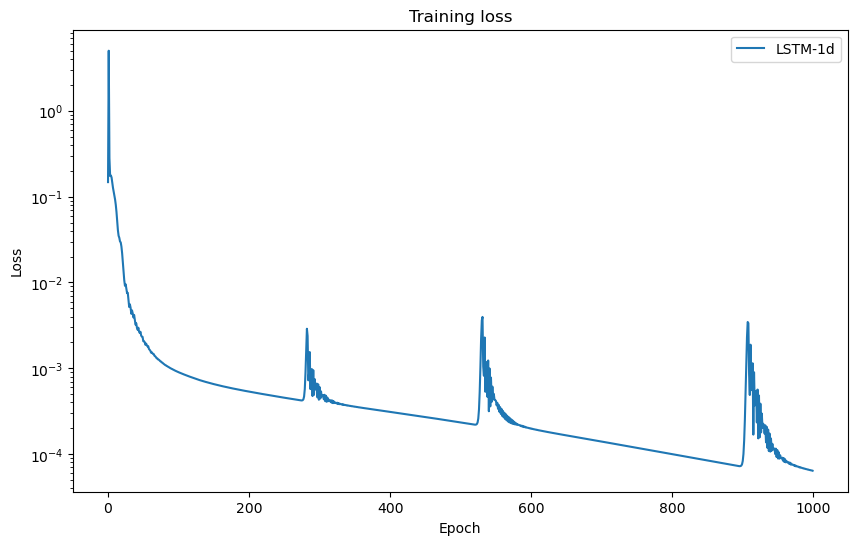

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(loss_hist, label="LSTM-1d")

plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [72]:
# make a prediction by running the algorithm
y_test_pred = model(x_test_tensor)
    
# apply the inverse scaler
y_train = scaler.inverse_transform(y_train_tensor.detach().numpy())
y_test = scaler.inverse_transform(y_test_tensor.detach().numpy())
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())

In [74]:
# RMS error
rms_train, rms_test = [], []

rms_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
rms_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print('Train Score:', rms_train)
print('Test Score:', rms_test)

Train Score: [46.493706]
Test Score: [2380.2256]


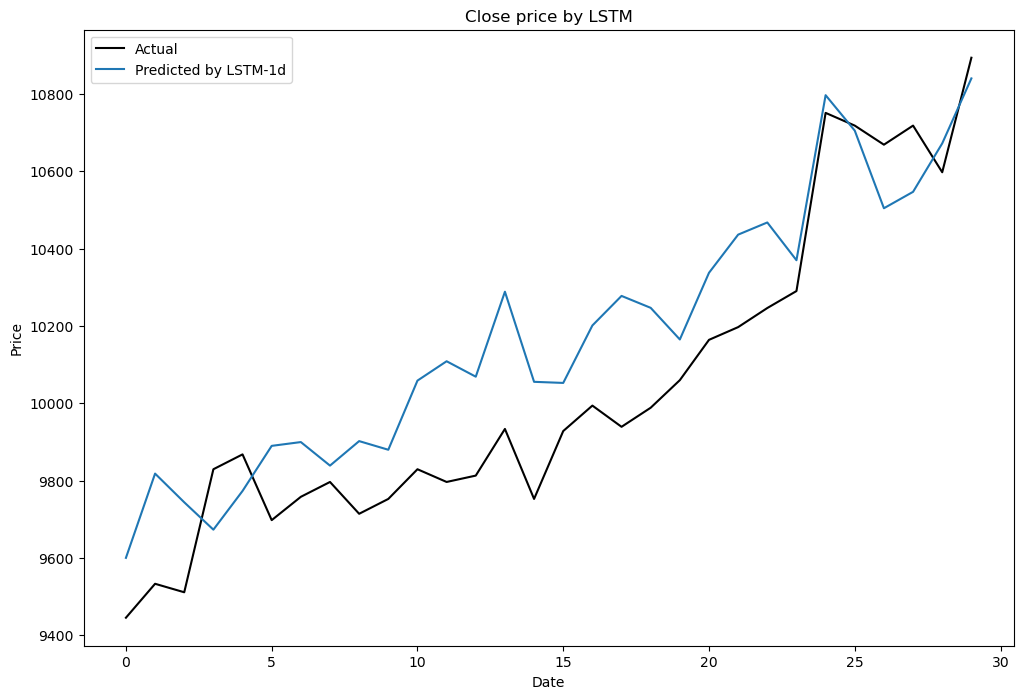

In [108]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(y_test[:30], 
        color='k',
        label='Actual')
ax.plot(y_test_pred[:30],
        label ='Predicted by LSTM-1d')

plt.title('Close price by LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Price up/down prediction and accuracy

In [100]:
diff = pd.DataFrame(data={'real': y_test.reshape(-1)})
diff['pred'] = y_test_pred.reshape(-1)
diff['real_diff'] = diff['real'].diff()
diff['pred_diff'] = diff['pred'] - diff['real']
diff = diff.dropna()
diff

,real,pred,real_diff,pred_diff
1,9533.324219,9818.232422,87.760742,284.908203
2,9511.383789,9744.049805,-21.940430,232.666016
3,9829.515625,9673.262695,318.131836,-156.252930
4,9867.911133,9773.352539,38.395508,-94.558594
5,9697.875000,9889.958984,-170.036133,192.083984
...,...,...,...,...
239,10191.527344,13654.069336,-27.424805,3462.541992
240,10290.257812,13527.168945,98.730469,3236.911133
241,10197.011719,13565.623047,-93.246094,3368.611328
242,10361.562500,13851.420898,164.550781,3489.858398


In [106]:
diff['is_coincide'] = diff['real_diff'].apply(np.sign) == diff['pred_diff'].apply(np.sign)
diff.head(30)

,real,pred,real_diff,pred_diff,is_coincide
1,9533.324219,9818.232422,87.760742,284.908203,True
2,9511.383789,9744.049805,-21.940430,232.666016,False
3,9829.515625,9673.262695,318.131836,-156.252930,False
4,9867.911133,9773.352539,38.395508,-94.558594,False
5,9697.875000,9889.958984,-170.036133,192.083984,False
6,9758.210938,9899.769531,60.335938,141.558594,True
7,9796.605469,9838.915039,38.394531,42.309570,True
8,9714.330078,9902.244141,-82.275391,187.914062,False
9,9752.725586,9879.889648,38.395508,127.164062,True
10,9829.515625,10058.689453,76.790039,229.173828,True
